# CIFAR10を10分で学習

CIFAR10をColabのGPU環境で10分だけ学習し、テストデータで一番認識率が高くなるものを目指します。

## 初期設定

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.utils import to_categorical

def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

def test_cifar10():
    test_num = 10
    start = np.random.randint(X_test.shape[0] - test_num)
    x_test = X_test[start:start+test_num]
    y_test = Y_test[start:start+test_num]

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        image = x_test[i]
        two_d = (np.reshape(image, (32, 32, 3)) * 255).astype(np.uint8)
        subplts[i].axis('off')
        subplts[i].imshow(two_d, interpolation='nearest')

    print(np.argmax(y_test, axis=1))

    preds = model.predict(x_test)
    print(np.argmax(preds, axis=1))
    
# CIFAR10データ読み込み
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

## ベースライン

LeNet のCNN  
LeNetは1998にLeCun先生が作られたCNNの直接の先祖となったネットワーク

In [0]:
model = Sequential()

model.add(Conv2D(20, (5, 5), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(50, (5, 5), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=1000, epochs=5)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 90us/sample - loss: 2.1791 - acc: 0.2047 - val_loss: 1.9596 - val_acc: 0.3226
Epoch 2/20
50000/50000 [==============================] - 4s 83us/sample - loss: 1.8673 - acc: 0.3444 - val_loss: 1.9063 - val_acc: 0.3321
Epoch 3/20
49000/50000 [============================>.] - ETA: 0s - loss: 1.7106 - acc: 0.3994

KeyboardInterrupt: ignored

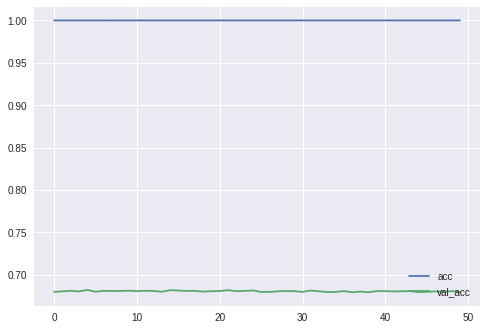

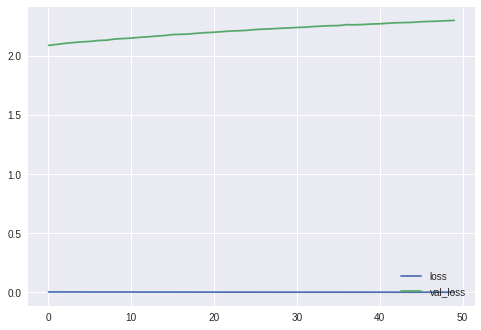

In [0]:
plot_history(history)

[8 5 3 9 3 5 7 1 8 5]
[8 5 4 9 9 5 4 1 8 3]


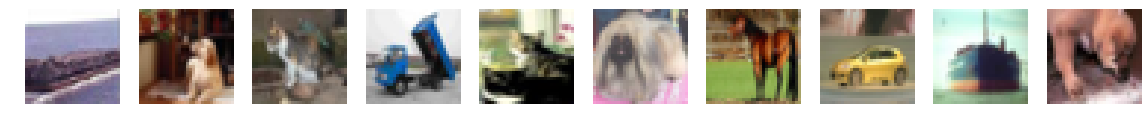

In [21]:
test_cifar10()
# 0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer, 5:dog, 6:frog, 7:horse, 8:ship, 9:truck

#### LeNet結果
4.1s/epoch  
150epoch/10m  
68%

## オプティマイザー変更

重みの変更手法をSGDより高速に学習するものを利用します。  

### Adam

よく使われているAdamを利用してみます。

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=1000, epochs=5)

Train on 50000 samples, validate on 10000 samples
Epoch 1/130
50000/50000 [==============================] - 4s 86us/sample - loss: 0.5931 - acc: 0.7997 - val_loss: 0.8782 - val_acc: 0.7049
Epoch 2/130
50000/50000 [==============================] - 4s 85us/sample - loss: 0.5713 - acc: 0.8069 - val_loss: 0.9263 - val_acc: 0.6888
Epoch 3/130
50000/50000 [==============================] - 4s 85us/sample - loss: 0.5556 - acc: 0.8114 - val_loss: 0.8779 - val_acc: 0.7054
Epoch 4/130
50000/50000 [==============================] - 4s 85us/sample - loss: 0.5270 - acc: 0.8227 - val_loss: 0.9030 - val_acc: 0.7055
Epoch 5/130
50000/50000 [==============================] - 4s 85us/sample - loss: 0.5106 - acc: 0.8286 - val_loss: 0.8947 - val_acc: 0.7082
Epoch 6/130
50000/50000 [==============================] - 4s 85us/sample - loss: 0.4915 - acc: 0.8341 - val_loss: 0.9092 - val_acc: 0.7014
Epoch 7/130
50000/50000 [==============================] - 4s 85us/sample - loss: 0.4564 - acc: 0.8485 - val_l

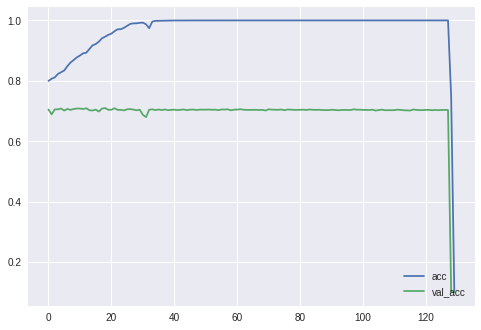

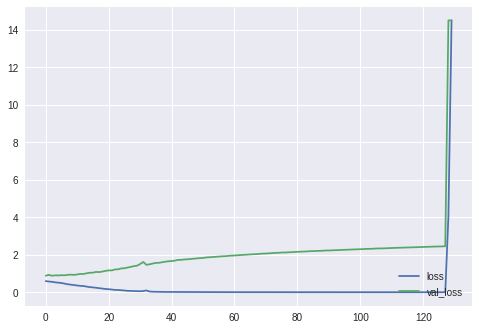

In [0]:
plot_history(history)

#### LeNet-Adam結果
4.1s/epoch  
30epoch程で上限  
70%

### Adabound

Adam は学習速度が高いが汎化能力がSGDよりも悪くなると言われています。  
Adaboundという改良手法が最近出て注目されているので試してみましょう。

https://qiita.com/Phoeboooo/items/f610affdcaaae0a28f34  
https://github.com/CyberZHG/keras-adabound

In [0]:
import tensorflow.keras as keras
import tensorflow.keras.backend as K


class AdaBound(keras.optimizers.Optimizer):
    """AdamBound optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        final_lr: float >= 0. Final (SGD) learning rate.
        base_lr: float >= 0. Used for loading the optimizer. Do not set the argument manually.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        gamma: float, 0 < gamma < 1. Convergence speed of the bound functions.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this algorithm.
    # References
        - [Adaptive Gradient Methods with Dynamic Bound of Learning Rate]
          (https://openreview.net/forum?id=Bkg3g2R9FX)
    """

    def __init__(self, lr=0.001, final_lr=0.1, base_lr=None,
                 beta_1=0.9, beta_2=0.999, gamma=0.001,
                 epsilon=None, decay=0., amsgrad=False, **kwargs):
        super(AdaBound, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.final_lr = K.variable(final_lr, name='final_lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.gamma = K.variable(gamma, name='gamma')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        if base_lr is None:
            self.base_lr = lr
        else:
            self.base_lr = base_lr
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))
        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1.0 - 1.0 / (self.gamma * t + 1.0))
        upper_bound = final_lr * (1.0 + 1.0 / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                step = lr_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                step = lr_t / (K.sqrt(v_t) + self.epsilon)
            p_t = p - K.minimum(K.maximum(step, lower_bound), upper_bound) * m_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(K.get_value(self.final_lr)),
                  'base_lr': self.base_lr,
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(K.get_value(self.gamma)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
      

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=AdaBound(lr=1e-3, final_lr=0.1),
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=1000, epochs=5)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 4s 87us/sample - loss: 0.5775 - acc: 0.8053 - val_loss: 0.8994 - val_acc: 0.7039
Epoch 2/30
50000/50000 [==============================] - 4s 86us/sample - loss: 0.5538 - acc: 0.8129 - val_loss: 0.9019 - val_acc: 0.6984
Epoch 3/30
50000/50000 [==============================] - 4s 86us/sample - loss: 0.5369 - acc: 0.8196 - val_loss: 0.8800 - val_acc: 0.7109
Epoch 4/30
50000/50000 [==============================] - 4s 86us/sample - loss: 0.5181 - acc: 0.8256 - val_loss: 0.9032 - val_acc: 0.7047
Epoch 5/30
50000/50000 [==============================] - 4s 85us/sample - loss: 0.4990 - acc: 0.8325 - val_loss: 0.9073 - val_acc: 0.7039
Epoch 6/30
50000/50000 [==============================] - 4s 86us/sample - loss: 0.4672 - acc: 0.8472 - val_loss: 0.9177 - val_acc: 0.7098
Epoch 7/30
50000/50000 [==============================] - 4s 86us/sample - loss: 0.4610 - acc: 0.8487 - val_loss: 0.

#### LeNet-Adabound結果
4.1s/epoch  
30epoch程で上限  
70%

## Batch Normalization の利用

Batch Normalizationは学習時のバックプロパゲーションの値を、バッチ毎によい分布になるように変換します。  
Batch Normalizationを利用することで高速に学習が進み認識率も高まります。

In [0]:
model = Sequential()

model.add(Conv2D(20, (5, 5), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(50, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=1000, epochs=5)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 6s 118us/sample - loss: 1.4817 - acc: 0.5126 - val_loss: 2.3684 - val_acc: 0.1273
Epoch 2/30
50000/50000 [==============================] - 5s 102us/sample - loss: 0.9485 - acc: 0.6701 - val_loss: 3.1797 - val_acc: 0.1258
Epoch 3/30
50000/50000 [==============================] - 5s 103us/sample - loss: 0.7621 - acc: 0.7381 - val_loss: 4.1771 - val_acc: 0.1133
Epoch 4/30
50000/50000 [==============================] - 5s 103us/sample - loss: 0.6005 - acc: 0.7963 - val_loss: 5.1980 - val_acc: 0.1669
Epoch 5/30
50000/50000 [==============================] - 5s 103us/sample - loss: 0.4403 - acc: 0.8609 - val_loss: 5.8501 - val_acc: 0.1660
Epoch 6/30
50000/50000 [==============================] - 5s 103us/sample - loss: 0.2960 - acc: 0.9169 - val_loss: 6.1063 - val_acc: 0.1949
Epoch 7/30
50000/50000 [==============================] - 5s 103us/sample - loss: 0.1781 - acc: 0.9614 - val_l

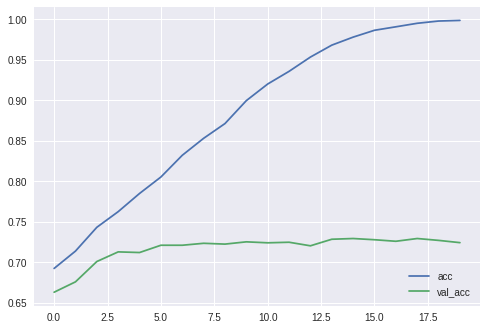

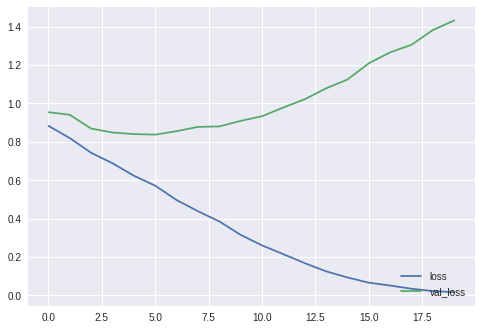

In [8]:
plot_history(history)

#### LeNet-BN-Adam結果
30epoch程で上限  
71%

学習データでは10エポック強でほぼ100%になっていることがわかります。

## 層を広くする

特徴を分類するニューロンを増やして、層を広く(wide)することで性能が上がることがあります。  
ここでは中間層のニューロンをすべて4倍にしてみます。

In [4]:
model = Sequential()

model.add(Conv2D(80, (5, 5), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(200, (5, 5), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(2000))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [7]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=1000, epochs=5)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 17s 337us/sample - loss: 0.8832 - acc: 0.6925 - val_loss: 0.9545 - val_acc: 0.6631
Epoch 2/20
50000/50000 [==============================] - 17s 334us/sample - loss: 0.8194 - acc: 0.7139 - val_loss: 0.9408 - val_acc: 0.6759
Epoch 3/20
50000/50000 [==============================] - 17s 336us/sample - loss: 0.7429 - acc: 0.7433 - val_loss: 0.8690 - val_acc: 0.7010
Epoch 4/20
50000/50000 [==============================] - 17s 336us/sample - loss: 0.6883 - acc: 0.7626 - val_loss: 0.8486 - val_acc: 0.7129
Epoch 5/20
50000/50000 [==============================] - 17s 336us/sample - loss: 0.6234 - acc: 0.7850 - val_loss: 0.8404 - val_acc: 0.7121
Epoch 6/20
50000/50000 [==============================] - 17s 335us/sample - loss: 0.5715 - acc: 0.8054 - val_loss: 0.8377 - val_acc: 0.7211
Epoch 7/20
50000/50000 [==============================] - 17s 336us/sample - loss: 0.4968 - acc: 0.8322 

#### LeNet-4wide-Adam結果
17.3s/epoch  
30epoch程で上限  
73%

## 層を深くする

## Conv2Dを軽量化する

## ResNet

## バッチサイズを小さくする

バッチサイズが大きいほうが計算速度が速い  
しかしバッチサイズが大きすぎると汎化能力が落ちる  

https://tech.nikkeibp.co.jp/dm/atcl/mag/15/00144/00002/

## Dropout の利用

## データ拡張

In [0]:
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)


## Mixup

## KerasのFashion-MNIST用のsample

KerasからTPUを使うためのサンプルでFasion-MNISTを学習するためのサンプル用ネットワークがありますので参考に。  
https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb

In [0]:
model = Sequential()
model.add(BatchNormalization(input_shape=X_train.shape[1:]))
model.add(Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(BatchNormalization(input_shape=X_train.shape[1:]))
model.add(Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization(input_shape=X_train.shape[1:]))
model.add(Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


In [20]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=1000, epochs=20)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 47s 931us/sample - loss: 3.3343 - acc: 0.2458 - val_loss: 3.2731 - val_acc: 0.1263
Epoch 2/20
50000/50000 [==============================] - 39s 788us/sample - loss: 1.9068 - acc: 0.3783 - val_loss: 6.9602 - val_acc: 0.1002
Epoch 3/20
50000/50000 [==============================] - 39s 789us/sample - loss: 1.6488 - acc: 0.4465 - val_loss: 6.9621 - val_acc: 0.1007
Epoch 4/20
50000/50000 [==============================] - 39s 790us/sample - loss: 1.4405 - acc: 0.5035 - val_loss: 6.8882 - val_acc: 0.1063
Epoch 5/20
50000/50000 [==============================] - 39s 788us/sample - loss: 1.2811 - acc: 0.5560 - val_loss: 6.0621 - val_acc: 0.1494
Epoch 6/20
50000/50000 [==============================] - 39s 788us/sample - loss: 1.1148 - acc: 0.6093 - val_loss: 3.6777 - val_acc: 0.2180
Epoch 7/20
50000/50000 [==============================] - 39s 787us/sample - loss: 0.9952 - acc: 0.6498 

#### Keras Fashion-MNIST sample
40s/epoch  
10分で15epoch  
80%